In [2]:
%matplotlib inline

import bisect
import collections
import h5py
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=6)
import sklearn.metrics
import sys
import tensorflow as tf

sys.path.append('../../prediction/')
sys.path.append('../../prediction/neural_networks/')

import batch.dataset_loaders
from neural_networks.updated_network import FFNN, RNN

In [9]:
timesteps = 40
debug_size = 10000
batch_size = 100
recurrent = timesteps > 1

filepath = '../../../data/datasets/ngsim_5_sec_40_feature_timesteps.h5'
# filepath = '../../../data/datasets/oct/bn_train_data.h5'
data = batch.dataset_loaders.risk_dataset_loader(
    filepath, 
    target_index=4, 
    timesteps=timesteps, 
    shuffle=True,
    debug_size=debug_size
)
data['y_train'] = np.hstack((1-data['y_train'], data['y_train']))
data['y_val'] = np.hstack((1-data['y_val'], data['y_val']))
ref_data = batch.dataset_loaders.risk_dataset_loader(
    filepath, 
    target_index=4, 
    timesteps=timesteps, 
    shuffle=False, 
    train_split=1.,
    mean=data['means'],
    std=data['stds'],
    debug_size=debug_size
)
ref_data['y_train'] = np.hstack((1-ref_data['y_train'], ref_data['y_train']))
ref_data['y_val'] = np.hstack((1-ref_data['y_val'], ref_data['y_val']))

In [10]:
data.keys()

dict_keys(['means', 'y_val', 'batch_idxs', 'stds', 'y_train', 'x_val', 'x_train', 'seeds'])

In [11]:
data['x_train'].shape

(4924, 40, 182)

(4924, 2)
0.0956539398863
471


(array([ 1146.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    85.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

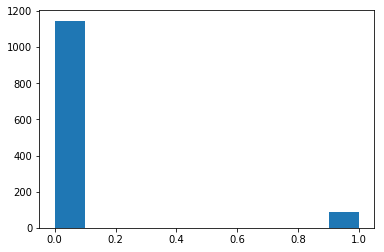

In [12]:
print(data['y_train'].shape)
print(np.mean(data['y_train'][:,1]))
print(len(np.where(data['y_train'][:,1] > 0)[0]))
plt.hist(data['y_val'][:,1])

In [13]:
tf.reset_default_graph()
if recurrent:
    model = RNN('test', data['x_train'].shape[-1], dropout_keep_prob=1., max_len=timesteps, batch_size=batch_size)
else:
    model = FFNN('test', data['x_train'].shape[-1], dropout_keep_prob=.5)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
model.train(data, n_epochs=10, batch_size=batch_size)

epoch: 1 / 10 batch: 50 / 50 loss: 0.3161693099141121

val epoch: 1 / 10 batch: 13 / 13 loss: 0.1972387834237172

epoch: 2 / 10 batch: 14 / 50 loss: 0.22224618813821248

KeyboardInterrupt: 

In [8]:
probs, preds = model.predict(ref_data['x_train'])

In [9]:
# threshold probs
thresh = 1e-8
probs[probs<thresh] = thresh
probs[probs > 1-thresh] = 1-thresh

In [10]:
losses = -np.sum(ref_data['y_train'] * np.log(probs), axis=-1)

In [11]:
def absidx2seedidx(absidx, batch_idxs, seeds):
    i = bisect.bisect_left(batch_idxs, absidx)
    if len(batch_idxs) > i and absidx == batch_idxs[i]:
        i += 1
    seed = seeds[i]
    if i > 0:
        veh_idx = absidx - batch_idxs[i - 1] + 1
    else:
        veh_idx = absidx + 1
    return seed, veh_idx

In [12]:
idxs = list(reversed(np.argsort(losses)))

# idxs = list(reversed(np.argsort(losses)))[:5000]
# nonzero_idxs = np.where(ref_data['y_train'][:,1]==.0)[0]
# idxs = [i for i in idxs if i in nonzero_idxs]


In [13]:
print(idxs[:10])
print(ref_data['y_train'][idxs][:10])
print(probs[idxs][:10])
print([absidx2seedidx(i, ref_data['batch_idxs'], ref_data['seeds']) for i in idxs[:10]])

[3943, 3944, 9157, 9160, 3942, 3901, 3543, 3941, 3900, 9155]
[[ 0.1  0.9]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 1.   0. ]
 [ 0.3  0.7]
 [ 0.2  0.8]
 [ 0.9  0.1]
 [ 0.6  0.4]
 [ 0.5  0.5]
 [ 0.5  0.5]]
[[ 0.9646   0.0354 ]
 [ 0.94377  0.05623]
 [ 0.92271  0.07729]
 [ 0.40777  0.59223]
 [ 0.60055  0.39945]
 [ 0.57188  0.42812]
 [ 0.99961  0.00039]
 [ 0.76391  0.23609]
 [ 0.40498  0.59502]
 [ 0.58904  0.41096]]
[(16, 194), (16, 195), (37, 158), (37, 161), (16, 193), (16, 152), (15, 44), (16, 192), (16, 151), (37, 156)]


(array([ 13.,   4.,   1.,   0.,   3.,   0.,   1.,   0.,   2.,   3.]),
 array([ 0.00039,  0.09711,  0.19382,  0.29053,  0.38724,  0.48395,
         0.58066,  0.67738,  0.77409,  0.8708 ,  0.96751]),
 <a list of 10 Patch objects>)

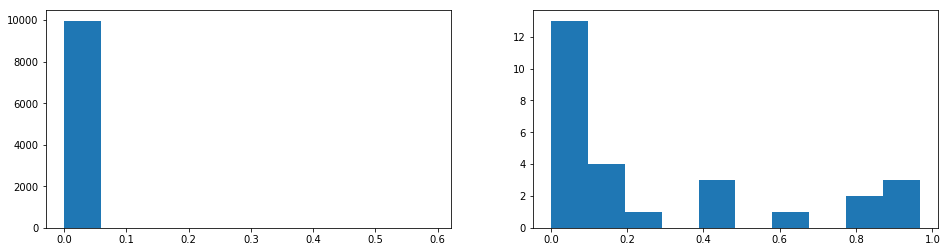

In [14]:
high_idxs = np.where(ref_data['y_train'][:,1] > 0)[0]
low_idxs = np.where(ref_data['y_train'][:,1] == 0)[0]
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(probs[low_idxs,1])
plt.subplot(1,2,2)
plt.hist(probs[high_idxs,1])

In [15]:
def compute_loss(probs, true, thresh=1e-8):
    probs[probs<thresh] = thresh
    probs[probs > 1-thresh] = 1-thresh
    losses = -np.sum(true * np.log(probs), axis=-1)
    return np.mean(losses)

In [16]:
model_stats = dict()
n_epochs = 2
sizes = [1000,2000,5000,10000,20000,50000,100000,1000000]
data['true_x_train'] = np.copy(data['x_train'])
data['true_y_train'] = np.copy(data['y_train'])
for n_samples in sizes:
    print(n_samples)
    data['x_train'] = np.copy(data['true_x_train'][:n_samples])
    data['y_train'] = np.copy(data['true_y_train'][:n_samples])
    
    tf.reset_default_graph()
    if recurrent:
        model = RNN(
            'test', 
            data['x_train'].shape[-1], 
            dropout_keep_prob=1., 
            max_len=timesteps, 
            batch_size=batch_size
        )
    else:
        model = FFNN(
            'test', 
            data['x_train'].shape[-1], 
            hidden_layer_dims=(128,128,64),
            dropout_keep_prob=1.
        )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    model.train(data, n_epochs=n_epochs, stop_early=True)
    
    probs, preds = model.predict(data['x_val'])
    val_loss = compute_loss(probs, data['y_val'])
    
    idxs = np.where(data['y_val'] > 0)[0]
    probs, preds = model.predict(data['x_val'][idxs])
    val_loss_nonzero = compute_loss(probs, data['y_val'][idxs])
    
    probs, preds = model.predict(data['x_train'])
    train_loss = compute_loss(probs, data['y_train'])
    
    idxs = np.where(data['y_train'] > 0)[0]
    probs, preds = model.predict(data['x_train'][idxs])
    train_loss_nonzero = compute_loss(probs, data['y_train'][idxs])
    
    
    model_stats[n_samples] = dict(
        val_loss=val_loss, 
        val_loss_nonzero=val_loss_nonzero,
        train_loss=train_loss,
        train_loss_nonzero=train_loss_nonzero
    )
    

1000
epoch: 1 / 2 batch: 10 / 10 loss: 0.4650003701448441

val epoch: 1 / 2 batch: 13 / 13 loss: 0.26794461332834685

epoch: 2 / 2 batch: 10 / 10 loss: 0.24529554694890976

val epoch: 2 / 2 batch: 13 / 13 loss: 0.21310331844366515

2000
epoch: 1 / 2 batch: 20 / 20 loss: 0.39232122227549554

val epoch: 1 / 2 batch: 13 / 13 loss: 0.2177807746025232

epoch: 2 / 2 batch: 20 / 20 loss: 0.22022393345832825

val epoch: 2 / 2 batch: 13 / 13 loss: 0.19609136134386063

5000
epoch: 1 / 2 batch: 50 / 50 loss: 0.31121012300252915

val epoch: 1 / 2 batch: 13 / 13 loss: 0.18361334445384833

epoch: 2 / 2 batch: 50 / 50 loss: 0.1991906288266182

val epoch: 2 / 2 batch: 13 / 13 loss: 0.19088800767293343

10000
epoch: 1 / 2 batch: 50 / 50 loss: 0.30594034314155577

val epoch: 1 / 2 batch: 13 / 13 loss: 0.19613700589308372

epoch: 2 / 2 batch: 50 / 50 loss: 0.19750670701265335

val epoch: 2 / 2 batch: 13 / 13 loss: 0.184326083614276

20000
epoch: 1 / 2 batch: 7 / 50 loss: 0.5507916382380894

KeyboardInterrupt: 

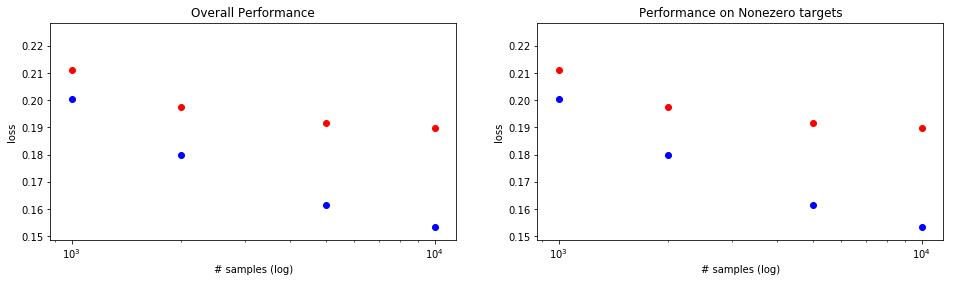

In [17]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Overall Performance')
plt.gca().set_xscale('log')
plt.xlabel('# samples (log)')
plt.ylabel('loss')
for (n_samples, stats) in model_stats.items():
    plt.scatter(n_samples, stats['val_loss'], c='red')
    plt.scatter(n_samples, stats['train_loss'], c='blue')

plt.subplot(1,2,2)
plt.title('Performance on Nonezero targets')
plt.xlabel('# samples (log)')
plt.ylabel('loss')
plt.gca().set_xscale('log')
for (n_samples, stats) in model_stats.items():
    plt.scatter(n_samples, stats['val_loss_nonzero'], c='red')
    plt.scatter(n_samples, stats['train_loss_nonzero'], c='blue')
plt.show()